In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math


# Data Preparation

In [17]:

import types
import pandas as pd
from ibm_botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_ad9575832fd1412f86f239390833793b = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='aqvB2RQYCjnXIqc6256jB-5wTa4ZF4I093bN_TjkKIRj',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_ad9575832fd1412f86f239390833793b.get_object(Bucket='default-donotdelete-pr-gghquivpww3tt4',Key='DataAfterCrossTable.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)
# Deleting data columns for data privacy clause with organization
df_data_2 = df_data_2.drop(['COMP', 'STATE OFF'], axis=1)
df_data_2.head()

,YEAR,PROD,Month,Sales
0,Y 08-09,MS-R,APR,2755.80
1,Y 08-09,MS-R,MAY,3128.81
2,Y 08-09,MS-R,JUN,2615.02
3,Y 08-09,MS-R,JUL,3106.45
4,Y 08-09,MS-R,AUG,3140.53


# ETL

In [18]:
# filtering data for product MS-R 
df_MS = df_data_2[df_data_2.PROD == "MS-R"]

# Month needs to be converted to number 
def month_converter(month):
    months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    return months.index(month) + 1


df_MS['NumMonth']=[month_converter(m) for m in list(df_MS.Month)]

# Creating a new column called YearMonth which can be used for sorting the data in a time series manner
def yearMonth(Y,M):
    if(M <= 3):
        return "20" + Y[-2:] + str(M).zfill(2)
    else:
        return "20" + Y[2:4] + str(M).zfill(2)
df_MS['YearMonth']=[yearMonth(Y,M) for (Y,M) in zip(list(df_MS.YEAR),list(df_MS.NumMonth))]

# There are multiple records available for a single month . we need to sum it to find aggregate sales for the month
df = df_MS.groupby(["YearMonth"], as_index=False).agg({"Sales": {"TotalSales" : sum}})

# No data present beyond 201808 

df = df[df.YearMonth <= "201808"]

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/pandas/core/groupby.py:4189: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [19]:
# Data
df.head(10)

,YearMonth,Sales
,,TotalSales
0,200804,412212.96
1,200805,474486.73
2,200806,348905.30
3,200807,408813.90
4,200808,399095.14
5,200809,399200.26
6,200810,413771.30
7,200811,405244.60
8,200812,402730.03


In [20]:
# Sort and create a time series
df = df.sort_values('YearMonth')
df.columns = ['YearMonth', 'Sales']

# we need only Sales values
dataset = df['Sales'].values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1,1))

# split into train and test sets with 2/3 & 1/3 data points
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

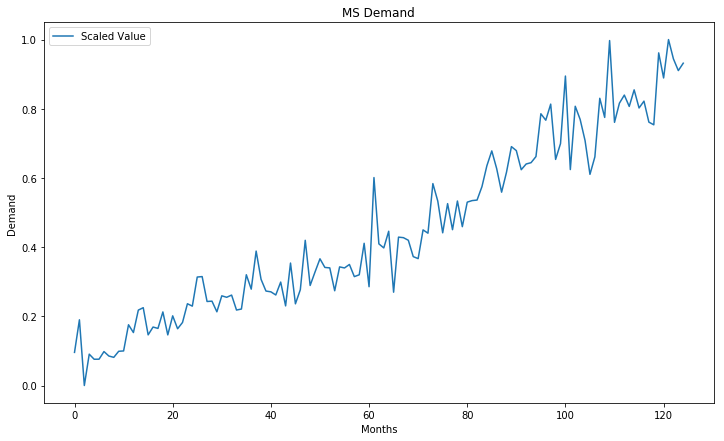

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('MS Demand')
plt.xlabel('Months')
plt.ylabel('Demand')
plt.plot(dataset, label='Scaled Value')
plt.legend()
plt.show()

In [22]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window), 0]
        dataX.append(a)
        dataY.append(dataset[i + window, 0])
    return numpy.array(dataX), numpy.array(dataY)


In [23]:
# fix random seed for reproducibility
numpy.random.seed(70)

# reshape into X=t and Y=t+1 and use window number of values to predict future. Current using only 1 value
window = 1
trainX, trainY = create_dataset(train, window)
testX, testY = create_dataset(test, window)

# reshape input to be [samples, time steps, features] as required for LSTM
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Model Fitting

In [24]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(12, input_shape=(1, window)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=4, verbose=2)

Epoch 1/100
 - 0s - loss: 0.0796
Epoch 2/100
 - 0s - loss: 0.0548
Epoch 3/100
 - 0s - loss: 0.0365
Epoch 4/100
 - 0s - loss: 0.0241
Epoch 5/100
 - 0s - loss: 0.0164
Epoch 6/100
 - 0s - loss: 0.0127
Epoch 7/100
 - 0s - loss: 0.0112
Epoch 8/100
 - 0s - loss: 0.0109
Epoch 9/100
 - 0s - loss: 0.0106
Epoch 10/100
 - 0s - loss: 0.0104
Epoch 11/100
 - 0s - loss: 0.0102
Epoch 12/100
 - 0s - loss: 0.0101
Epoch 13/100
 - 0s - loss: 0.0099
Epoch 14/100
 - 0s - loss: 0.0097
Epoch 15/100
 - 0s - loss: 0.0096
Epoch 16/100
 - 0s - loss: 0.0094
Epoch 17/100
 - 0s - loss: 0.0093
Epoch 18/100
 - 0s - loss: 0.0091
Epoch 19/100
 - 0s - loss: 0.0089
Epoch 20/100
 - 0s - loss: 0.0087
Epoch 21/100
 - 0s - loss: 0.0088
Epoch 22/100
 - 0s - loss: 0.0085
Epoch 23/100
 - 0s - loss: 0.0083
Epoch 24/100
 - 0s - loss: 0.0082
Epoch 25/100
 - 0s - loss: 0.0081
Epoch 26/100
 - 0s - loss: 0.0079
Epoch 27/100
 - 0s - loss: 0.0077
Epoch 28/100
 - 0s - loss: 0.0076
Epoch 29/100
 - 0s - loss: 0.0075
Epoch 30/100
 - 0s - lo

In [25]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 50541.95 RMSE
Test Score: 82370.48 RMSE


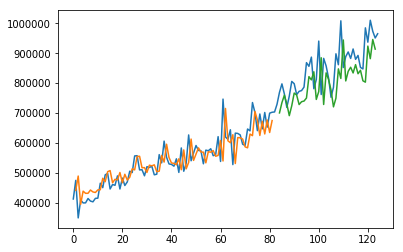

In [26]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(window*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [27]:
# Improving Model 

In [28]:
# reshape into X=t and Y=t+1 and use window number of values to predict future. Current using only 1 value
window = 24
trainX, trainY = create_dataset(train, window)
testX, testY = create_dataset(test, window)

# reshape input to be [samples, time steps, features] as required for LSTM
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(24, input_shape=(1, window)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=4, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])



Epoch 1/100
 - 0s - loss: 0.0664
Epoch 2/100
 - 0s - loss: 0.0065
Epoch 3/100
 - 0s - loss: 0.0065
Epoch 4/100
 - 0s - loss: 0.0040
Epoch 5/100
 - 0s - loss: 0.0041
Epoch 6/100
 - 0s - loss: 0.0039
Epoch 7/100
 - 0s - loss: 0.0037
Epoch 8/100
 - 0s - loss: 0.0038
Epoch 9/100
 - 0s - loss: 0.0038
Epoch 10/100
 - 0s - loss: 0.0037
Epoch 11/100
 - 0s - loss: 0.0037
Epoch 12/100
 - 0s - loss: 0.0036
Epoch 13/100
 - 0s - loss: 0.0035
Epoch 14/100
 - 0s - loss: 0.0036
Epoch 15/100
 - 0s - loss: 0.0034
Epoch 16/100
 - 0s - loss: 0.0034
Epoch 17/100
 - 0s - loss: 0.0033
Epoch 18/100
 - 0s - loss: 0.0033
Epoch 19/100
 - 0s - loss: 0.0034
Epoch 20/100
 - 0s - loss: 0.0032
Epoch 21/100
 - 0s - loss: 0.0032
Epoch 22/100
 - 0s - loss: 0.0032
Epoch 23/100
 - 0s - loss: 0.0031
Epoch 24/100
 - 0s - loss: 0.0031
Epoch 25/100
 - 0s - loss: 0.0029
Epoch 26/100
 - 0s - loss: 0.0030
Epoch 27/100
 - 0s - loss: 0.0030
Epoch 28/100
 - 0s - loss: 0.0028
Epoch 29/100
 - 0s - loss: 0.0029
Epoch 30/100
 - 0s - lo

In [29]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 27344.37 RMSE
Test Score: 35216.36 RMSE


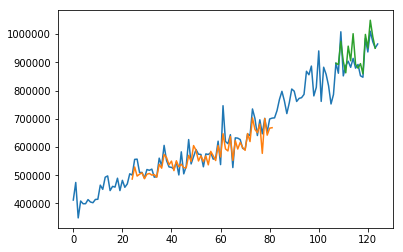

In [30]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(window*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()